In [13]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import warnings
from shap.plots._labels import labels
from shap.utils import format_value, ordinal_str,safe_isinstance, OpChain, format_value
from shap.plots._utils import convert_ordering, convert_color, merge_nodes, get_sort_order, sort_inds, dendrogram_coords
from shap.plots import colors

import scipy
import copy
from shap import Explanation, Cohorts

# import models and machine learning dataset

In [15]:
Xe_model=joblib.load("GBR_Xe_M.pkl")
Kr_model=joblib.load("GBR_Kr_M.pkl")

In [32]:
data = pd.read_excel("MLdataset.xlsx")
X_Xe = pd.DataFrame(data,columns = ['PLD', 'LCD', 'Density', 'ASA','VF','Xe_heat'])
X_Kr = pd.DataFrame(data,columns = ['PLD', 'LCD', 'Density', 'ASA','VF','Kr_heat'])

# calculate SHAP value

In [33]:
explainer_Xe = shap.Explainer(Xe_model)
explainer_Kr = shap.Explainer(Kr_model)

shap_values_Xe = explainer_Xe(X_Xe)
shap_values_Kr = explainer_Kr(X_Kr)

In [35]:
feature_Xe=['PLD', 'LCD', 'ρ', 'ASA','VF','$\mathregular {ΔH_{Xe}}$']
feature_Kr=['PLD', 'LCD', 'ρ', 'ASA','VF','$\mathregular {ΔH_{Kr}}$']

# plot

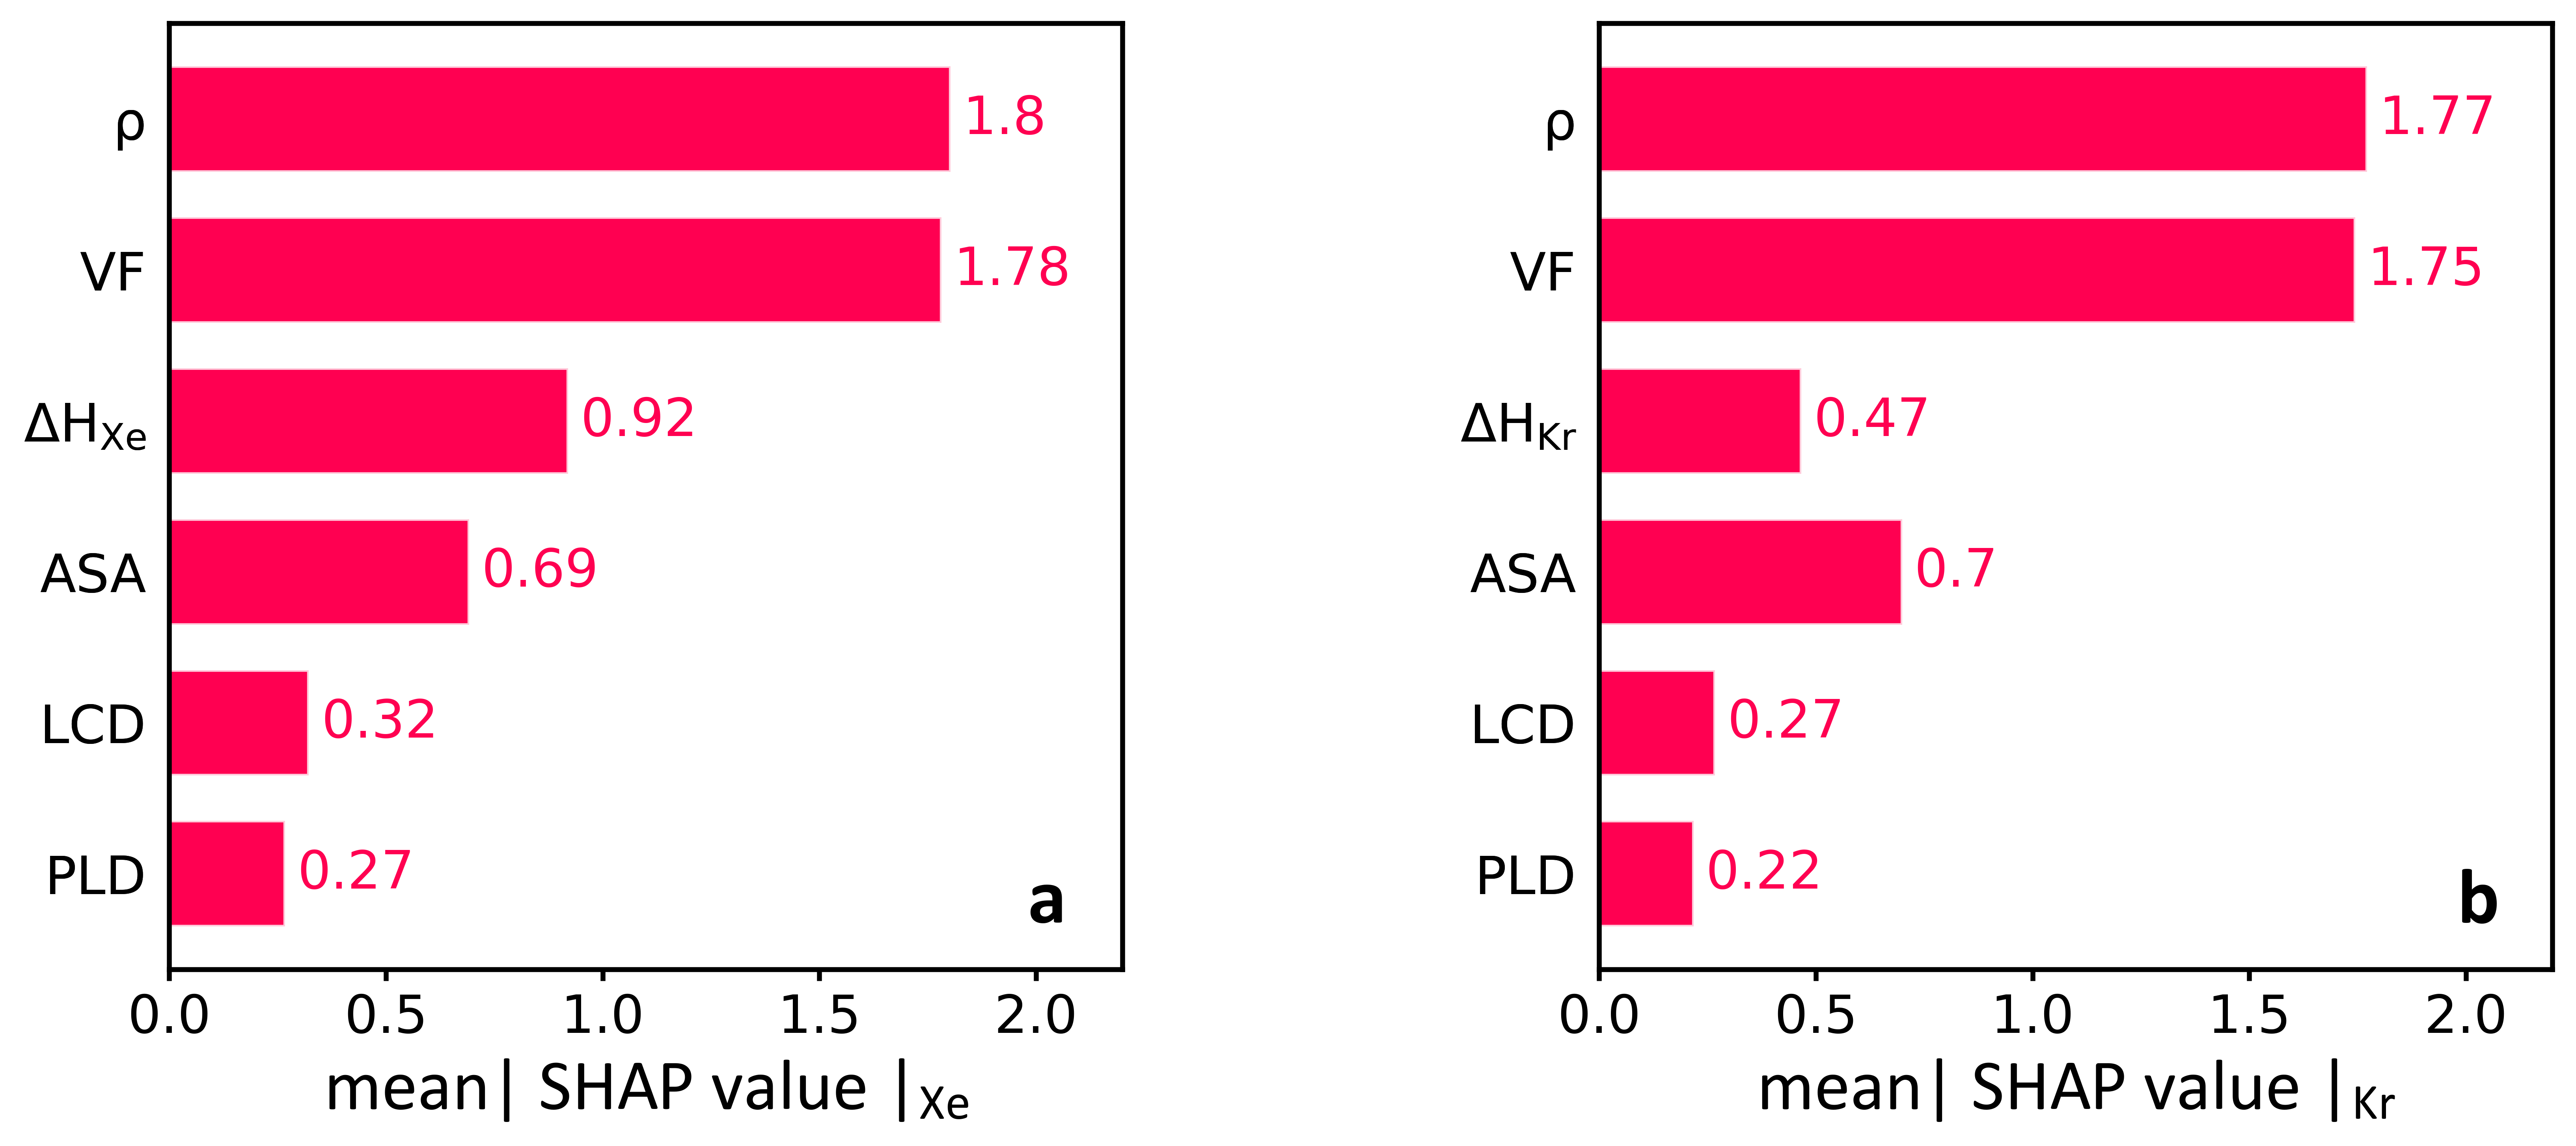

In [40]:
fig = pl.figure(figsize=(13,5),dpi=600)


ax = fig.add_subplot(121)
clustering_cutoff=0.5
shap_values = shap_values_Xe
feature_names = feature_Xe
cohorts = {"": shap_values}
cohort_labels = list(cohorts.keys())
cohort_exps = list(cohorts.values())
order=Explanation.abs
feature_order = np.argsort(np.mean([np.argsort(convert_ordering(order, Explanation(shap_values[i]))) for i in range(shap_values.shape[0])], 0))
for i in range(len(cohort_exps)):
    cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    op_history = cohort_exps[0].op_history
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    show_data = len(op_history) == 0
    cohort_sizes = []
    for exp in cohort_exps:
        for op in exp.op_history:
            if op.get("collapsed_instances", False):
                cohort_sizes.append(op["prev_shape"][0])
                break
    max_display = len(feature_names)
    num_features = min(max_display, len(values[0]))
    max_display = min(max_display, num_features)
    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    if num_features < len(shap_values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features-1, len(values[0]))])
        values[:,feature_order[num_features-1]] = np.sum([values[:,feature_order[i]] for i in range(num_features-1, len(values[0]))], 0)
    yticklabels = []
    for i in feature_inds:
            yticklabels.append(feature_names[i])
    row_height = 0.5
    total_width = 0.7
    bar_width = total_width / len(values)
    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        pl.barh(
            y_pos + ypos_offset, values[i,feature_inds],
            bar_width, align='center',
            color=[colors.blue_rgb if values[i,feature_inds[j]] <= 0 else colors.red_rgb for j in range(len(y_pos))],
            hatch=None, edgecolor=(1,1,1,0.8), label=f"{cohort_labels[i]} [{cohort_sizes[i] if i < len(cohort_sizes) else None}]"
        )
    pl.yticks(list(y_pos) + list(y_pos + 1e-8),  yticklabels + [l.split('=')[-1] for l in yticklabels], fontsize=16)
    xlen = pl.xlim()[1] - pl.xlim()[0]
    fig = pl.gcf()
    ax = pl.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    bbox_to_xscale = xlen/width
    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        for j in range(len(y_pos)):
            ind = feature_order[j]
            pl.text(
                    values[i,ind] + (5/72)*bbox_to_xscale, y_pos[j] + ypos_offset, format_value(values[i,ind], '%0.02f'),
                    horizontalalignment='left', verticalalignment='center', color=colors.red_rgb,
                    fontsize=16
                )
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    xmin,xmax = pl.gca().get_xlim()
    ymin,ymax = pl.gca().get_ylim()
    pl.xlabel("mean| SHAP value |$\mathregular {_{Xe}}$", fontdict={'family':'Calibri','size':22})
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.tick_params(axis='both', which='both', direction='out',width=1.5,labelsize=16)
    ax.minorticks_off()
    ax.text(0.9,0.05,"a",fontdict={'family':'Calibri','size':24,'fontweight':'bold'},transform=ax.transAxes)
    pl.xlim(0, 2.2)
    

bx = fig.add_subplot(122)

ustering_cutoff=0.5
shap_values = shap_values_Kr
eature_order = np.argsort(np.mean([np.argsort(convert_ordering(order, Explanation(shap_values[i]))) for i in range(shap_values.shape[0])], 0))
feature_names = feature_Kr
cohorts = {"": shap_values}
cohort_labels = list(cohorts.keys())
cohort_exps = list(cohorts.values())
for i in range(len(cohort_exps)):
    cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    op_history = cohort_exps[0].op_history
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    show_data = len(op_history) == 0
    cohort_sizes = []
    for exp in cohort_exps:
        for op in exp.op_history:
            if op.get("collapsed_instances", False):
                cohort_sizes.append(op["prev_shape"][0])
                break
    max_display = len(feature_names)
    num_features = min(max_display, len(values[0]))
    max_display = min(max_display, num_features)
    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features-1, len(values[0]))])
        values[:,feature_order[num_features-1]] = np.sum([values[:,feature_order[i]] for i in range(num_features-1, len(values[0]))], 0)
    yticklabels = []
    for i in feature_inds:
            yticklabels.append(feature_names[i])
    row_height = 0.5
    total_width = 0.7
    bar_width = total_width / len(values)
    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        pl.barh(
            y_pos + ypos_offset, values[i,feature_inds],
            bar_width, align='center',
            color=[colors.blue_rgb if values[i,feature_inds[j]] <= 0 else colors.red_rgb for j in range(len(y_pos))],
            hatch=None, edgecolor=(1,1,1,0.8), label=f"{cohort_labels[i]} [{cohort_sizes[i] if i < len(cohort_sizes) else None}]"
        )
    pl.yticks(list(y_pos) + list(y_pos + 1e-8),  yticklabels + [l.split('=')[-1] for l in yticklabels], fontsize=16)
    xlen = pl.xlim()[1] - pl.xlim()[0]
    fig = pl.gcf()
    ax = pl.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    bbox_to_xscale = xlen/width
    for i in range(len(values)):
        ypos_offset = - ((i - len(values) / 2) * bar_width + bar_width / 2)
        for j in range(len(y_pos)):
            ind = feature_order[j]
            pl.text(
                    values[i,ind] + (5/72)*bbox_to_xscale, y_pos[j] + ypos_offset, format_value(values[i,ind], '%0.02f'),
                    horizontalalignment='left', verticalalignment='center', color=colors.red_rgb,
                    fontsize=16
                )
    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    xmin,xmax = pl.gca().get_xlim()
    ymin,ymax = pl.gca().get_ylim()
    pl.xlabel("mean| SHAP value |$\mathregular {_{Kr}}$", fontdict={'family':'Calibri','size':22})
    bx.spines['top'].set_linewidth(1.5)
    bx.spines['bottom'].set_linewidth(1.5)
    bx.spines['left'].set_linewidth(1.5)
    bx.spines['right'].set_linewidth(1.5)
    bx.tick_params(axis='both', which='both', direction='out',width=1.5,labelsize=16)
    bx.minorticks_off()
    bx.text(0.9,0.05,"b",fontdict={'family':'Calibri','size':24,'fontweight':'bold'},transform=bx.transAxes)
    pl.xlim(0, 2.2)
    
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.35)

plt.show()

In [43]:
def beeswarm(shap_values, max_display=10, order=Explanation.abs.mean(0),
             clustering=None, cluster_threshold=0.5, color=None,
             axis_color="#333333", alpha=1, show=True, log_scale=False,
             color_bar=True, plot_size="auto", color_bar_label=labels["FEATURE_VALUE"]):
    """Create a SHAP beeswarm plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : Explanation
        This is an Explanation object containing a matrix of SHAP values (# samples x # features).

    max_display : int
        How many top features to include in the plot (default is 20, or 7 for interaction plots)

    plot_size : "auto" (default), float, (float, float), or None
        What size to make the plot. By default the size is auto-scaled based on the number of
        features that are being displayed. Passing a single float will cause each row to be that 
        many inches high. Passing a pair of floats will scale the plot by that
        number of inches. If None is passed then the size of the current figure will be left
        unchanged.
    """
    fig = pl.figure(figsize=(6.5,5),dpi=600)
    
    if not isinstance(shap_values, Explanation):
        raise ValueError("the beeswarm plot requires Explanation object as the `shap_values` argument")

    if len(shap_values.shape) == 1:
        raise ValueError(
            "The beeswarm plot does not support plotting a single instance, please pass "
            "an explanation matrix with many instances!"
        )
    elif len(shap_values.shape) > 2:
        raise ValueError(
            "The beeswarm plot does not support plotting explanations with instances that have more "
            "than one dimension!"
        )
    shap_exp = shap_values

    values = np.copy(shap_exp.values)
    features = shap_exp.data
        
    feature_names = feature_Xe

    order = convert_ordering(order, values)
    
    if color is None:
        if features is not None:
            color = colors.red_blue
        else:
            color = colors.blue_rgb
    color = convert_color(color)

    idx2cat = None
    # convert from a DataFrame or other types
    if str(type(features)) == "<class 'pandas.core.frame.DataFrame'>":
        if feature_names is None:
            feature_names = features.columns
        # feature index to category flag
        idx2cat = features.dtypes.astype(str).isin(["object", "category"]).tolist()
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = values.shape[1]

    if features is not None:
        shape_msg = "The shape of the matrix does not match the shape of the " \
                    "provided data matrix."
        if num_features - 1 == features.shape[1]:
            assert False, shape_msg + " Perhaps the extra column in the shap_values matrix is the " \
                          "constant offset? Of so just pass shap_values[:,:-1]."
        else:
            assert num_features == features.shape[1], shape_msg

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(num_features)])

    if log_scale:
        pl.xscale('symlog')

    if clustering is None:
        partition_tree = getattr(shap_values, "clustering", None)
        if partition_tree is not None and partition_tree.var(0).sum() == 0:
            partition_tree = partition_tree[0]
        else:
            partition_tree = None
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering
    
    if partition_tree is not None:
        assert partition_tree.shape[1] == 4, "The clustering provided by the Explanation object does not seem to be a partition tree (which is all shap.plots.bar supports)!"

    # plotting SHAP interaction values
    if len(values.shape) == 3:

        if plot_type == "compact_dot":
            new_values = values.reshape(values.shape[0], -1)
            new_features = np.tile(features, (1, 1, features.shape[1])).reshape(features.shape[0], -1)

            new_feature_names = []
            for c1 in feature_names:
                for c2 in feature_names:
                    if c1 == c2:
                        new_feature_names.append(c1)
                    else:
                        new_feature_names.append(c1 + "* - " + c2)

            return beeswarm(
                new_values, new_features, new_feature_names,
                max_display=max_display, plot_type="dot", color=color, axis_color=axis_color,
                title=title, alpha=alpha, show=show, sort=sort,
                color_bar=color_bar, plot_size=plot_size, class_names=class_names,
                color_bar_label="*" + color_bar_label
            )

        if max_display is None:
            max_display = 7
        else:
            max_display = min(len(feature_names), max_display)

        interaction_sort_inds = order#np.argsort(-np.abs(values.sum(1)).sum(0))

        # get plotting limits
        delta = 1.0 / (values.shape[1] ** 2)
        slow = np.nanpercentile(values, delta)
        shigh = np.nanpercentile(values, 100 - delta)
        v = max(abs(slow), abs(shigh))
        slow = -v
        shigh = v

        pl.figure(figsize=(1.5 * max_display + 1, 0.8 * max_display + 1))
        pl.subplot(1, max_display, 1)
        proj_values = values[:, interaction_sort_inds[0], interaction_sort_inds]
        proj_values[:, 1:] *= 2  # because off diag effects are split in half
        beeswarm(
            proj_values, features[:, interaction_sort_inds] if features is not None else None,
            feature_names=feature_names[interaction_sort_inds],
            sort=False, show=False, color_bar=False,
            plot_size=None,
            max_display=max_display
        )
        pl.xlim((slow, shigh))
        pl.xlabel("")
        title_length_limit = 11
        pl.title(shorten_text(feature_names[interaction_sort_inds[0]], title_length_limit))
        for i in range(1, min(len(interaction_sort_inds), max_display)):
            ind = interaction_sort_inds[i]
            pl.subplot(1, max_display, i + 1)
            proj_values = values[:, ind, interaction_sort_inds]
            proj_values *= 2
            proj_values[:, i] /= 2  # because only off diag effects are split in half
            summary(
                proj_values, features[:, interaction_sort_inds] if features is not None else None,
                sort=False,
                feature_names=["" for i in range(len(feature_names))],
                show=False,
                color_bar=False,
                plot_size=None,
                max_display=max_display
            )
            pl.xlim((slow, shigh))
            pl.xlabel("")
            if i == min(len(interaction_sort_inds), max_display) // 2:
                pl.xlabel(labels['INTERACTION_VALUE'])
            pl.title(shorten_text(feature_names[ind], title_length_limit))
        pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
        pl.subplots_adjust(hspace=0, wspace=0.1)
        if show:
            pl.show()
        return

    # determine how many top features we will plot
    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(feature_names))

    # iteratively merge nodes until we can cut off the smallest feature values to stay within
    # num_features without breaking a cluster tree
    orig_inds = [[i] for i in range(len(feature_names))]
    orig_values = values.copy()
    while True:
        feature_order = convert_ordering(order, Explanation(np.abs(values)))
        if partition_tree is not None:

            # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
            clust_order = sort_inds(partition_tree, np.abs(values))

            # now relax the requirement to match the parition tree ordering for connections above cluster_threshold
            dist = scipy.spatial.distance.squareform(scipy.cluster.hierarchy.cophenet(partition_tree))
            feature_order = get_sort_order(dist, clust_order, cluster_threshold, feature_order)
        
            # if the last feature we can display is connected in a tree the next feature then we can't just cut
            # off the feature ordering, so we need to merge some tree nodes and then try again.
            if max_display < len(feature_order) and dist[feature_order[max_display-1],feature_order[max_display-2]] <= cluster_threshold:
                #values, partition_tree, orig_inds = merge_nodes(values, partition_tree, orig_inds)
                partition_tree, ind1, ind2 = merge_nodes(np.abs(values), partition_tree)
                for i in range(len(values)):
                    values[:,ind1] += values[:,ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    # here we build our feature names, accounting for the fact that some features might be merged together
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    feature_names_new = []
    for pos,inds in enumerate(orig_inds):
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        elif len(inds) <= 2:
            feature_names_new.append(" + ".join([feature_names[i] for i in inds]))
        else:
            max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
            feature_names_new.append(feature_names[inds[max_ind]] + " + %d other features" % (len(inds)-1))
    feature_names = feature_names_new

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features-1, len(values[0]))])
        values[:,feature_order[num_features-1]] = np.sum([values[:,feature_order[i]] for i in range(num_features-1, len(values[0]))], 0)
    
    # build our y-tick labels
    yticklabels = [feature_names[i] for i in feature_inds]
    if num_features < len(values[0]):
        yticklabels[-1] = "Sum of %d other features" % num_cut
    
    row_height = 0.4
    pl.axvline(x=0, color="#999999", zorder=-1)

    # make the beeswarm dots
    for pos, i in enumerate(reversed(feature_inds)):
        pl.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
        shaps = values[:, i]
        fvalues = None if features is None else features[:, i]
        inds = np.arange(len(shaps))
        np.random.shuffle(inds)
        if fvalues is not None:
            fvalues = fvalues[inds]
        shaps = shaps[inds]
        colored_feature = True
        try:
            if idx2cat is not None and idx2cat[i]: # check categorical feature
                colored_feature = False
            else:
                fvalues = np.array(fvalues, dtype=np.float64)  # make sure this can be numeric
        except:
            colored_feature = False
        N = len(shaps)
        # hspacing = (np.max(shaps) - np.min(shaps)) / 200
        # curr_bin = []
        nbins = 100
        quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
        inds = np.argsort(quant + np.random.randn(N) * 1e-6)
        layer = 0
        last_bin = -1
        ys = np.zeros(N)
        for ind in inds:
            if quant[ind] != last_bin:
                layer = 0
            ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
            layer += 1
            last_bin = quant[ind]
        ys *= 0.9 * (row_height / np.max(ys + 1))

        if safe_isinstance(color, "matplotlib.colors.Colormap") and features is not None and colored_feature:
            # trim the color range, but prevent the color range from collapsing
            vmin = np.nanpercentile(fvalues, 5)
            vmax = np.nanpercentile(fvalues, 95)
            if vmin == vmax:
                vmin = np.nanpercentile(fvalues, 1)
                vmax = np.nanpercentile(fvalues, 99)
                if vmin == vmax:
                    vmin = np.min(fvalues)
                    vmax = np.max(fvalues)
            if vmin > vmax: # fixes rare numerical precision issues
                vmin = vmax

            assert features.shape[0] == len(shaps), "Feature and SHAP matrices must have the same number of rows!"

            # plot the nan fvalues in the interaction feature as grey
            nan_mask = np.isnan(fvalues)
            pl.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#777777", vmin=vmin,
                        vmax=vmax, s=16, alpha=alpha, linewidth=0,
                        zorder=3, rasterized=len(shaps) > 500)

            # plot the non-nan fvalues colored by the trimmed feature value
            cvals = fvalues[np.invert(nan_mask)].astype(np.float64)
            cvals_imp = cvals.copy()
            cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
            cvals[cvals_imp > vmax] = vmax
            cvals[cvals_imp < vmin] = vmin
            pl.scatter(shaps[np.invert(nan_mask)], pos + ys[np.invert(nan_mask)],
                        cmap=color, vmin=vmin, vmax=vmax, s=16,
                        c=cvals, alpha=alpha, linewidth=0,
                        zorder=3, rasterized=len(shaps) > 500)
        else:

            pl.scatter(shaps, pos + ys, s=16, alpha=alpha, linewidth=0, zorder=3,
                        color=color if colored_feature else "#777777", rasterized=len(shaps) > 500)


    #draw the color bar
    if safe_isinstance(color, "matplotlib.colors.Colormap") and color_bar and features is not None:
        import matplotlib.cm as cm
        m = cm.ScalarMappable(cmap=color)
        m.set_array([0, 1])
        cb = pl.colorbar(m, ticks=[0, 1], aspect=80)
        cb.set_ticklabels([labels['FEATURE_VALUE_LOW'], labels['FEATURE_VALUE_HIGH']])
        cb.set_label(color_bar_label, fontdict={'family':'Calibri','size':22})
        cb.ax.tick_params(labelsize=16, length=0)
        cb.set_alpha(1)
        cb.outline.set_visible(False)

    pl.gca().xaxis.set_ticks_position('bottom')
    pl.gca().yaxis.set_ticks_position('none')
    pl.gca().tick_params(color=axis_color, labelcolor=axis_color)
    pl.yticks(range(len(feature_inds)), reversed(yticklabels), fontsize=16)
    pl.ylim(-1, len(feature_inds))
    pl.xlabel("SHAP value", fontdict={'family':'Calibri','size':22})
    
    pl.gca().spines['top'].set_linewidth(1.5)
    pl.gca().spines['bottom'].set_linewidth(1.5)
    pl.gca().spines['left'].set_linewidth(1.5)
    pl.gca().spines['right'].set_linewidth(1.5)
    pl.tick_params(axis='both', which='both', direction='out',width=1.5,labelsize=16)
    
#     pl.text(21.5,-0.7,"d",fontdict={'family':'Calibri','size':24,'fontweight':'bold'})
    pl.text(20,-0.7,"d",fontdict={'family':'Calibri','size':24,'fontweight':'bold'})
    
    if show:
        pl.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


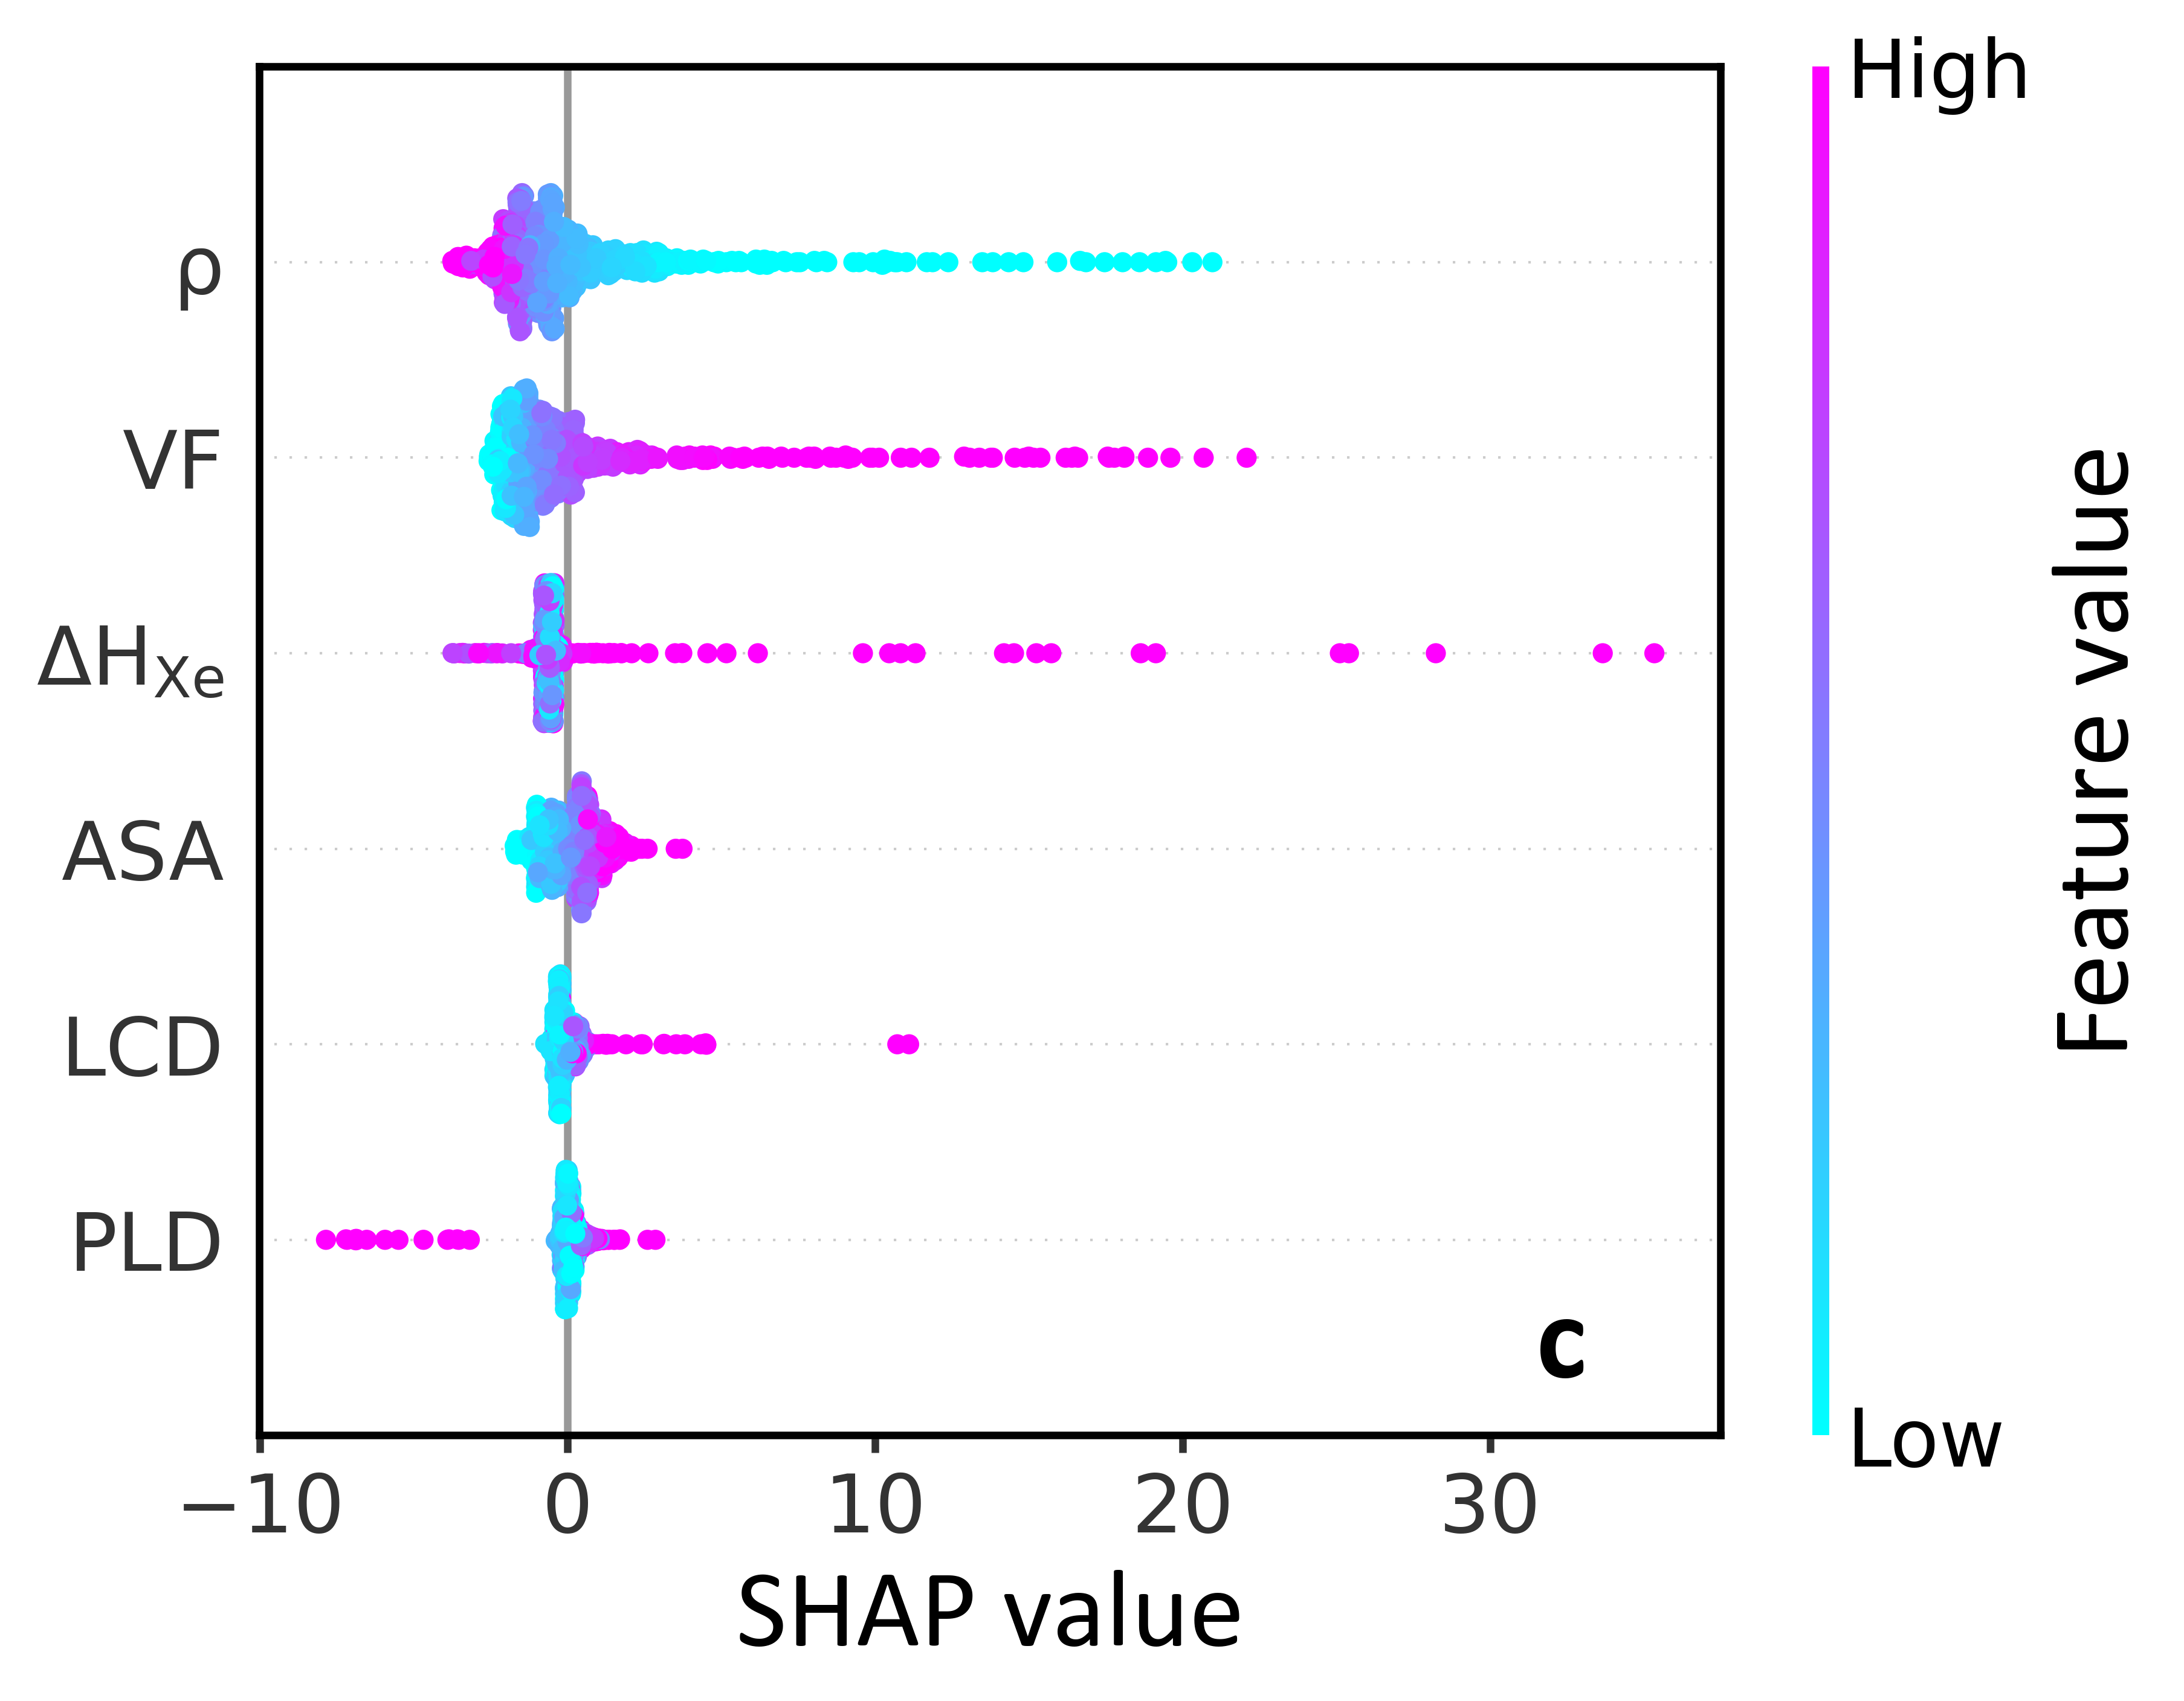

In [38]:
beeswarm(shap_values_Xe,color=pl.get_cmap("cool"))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


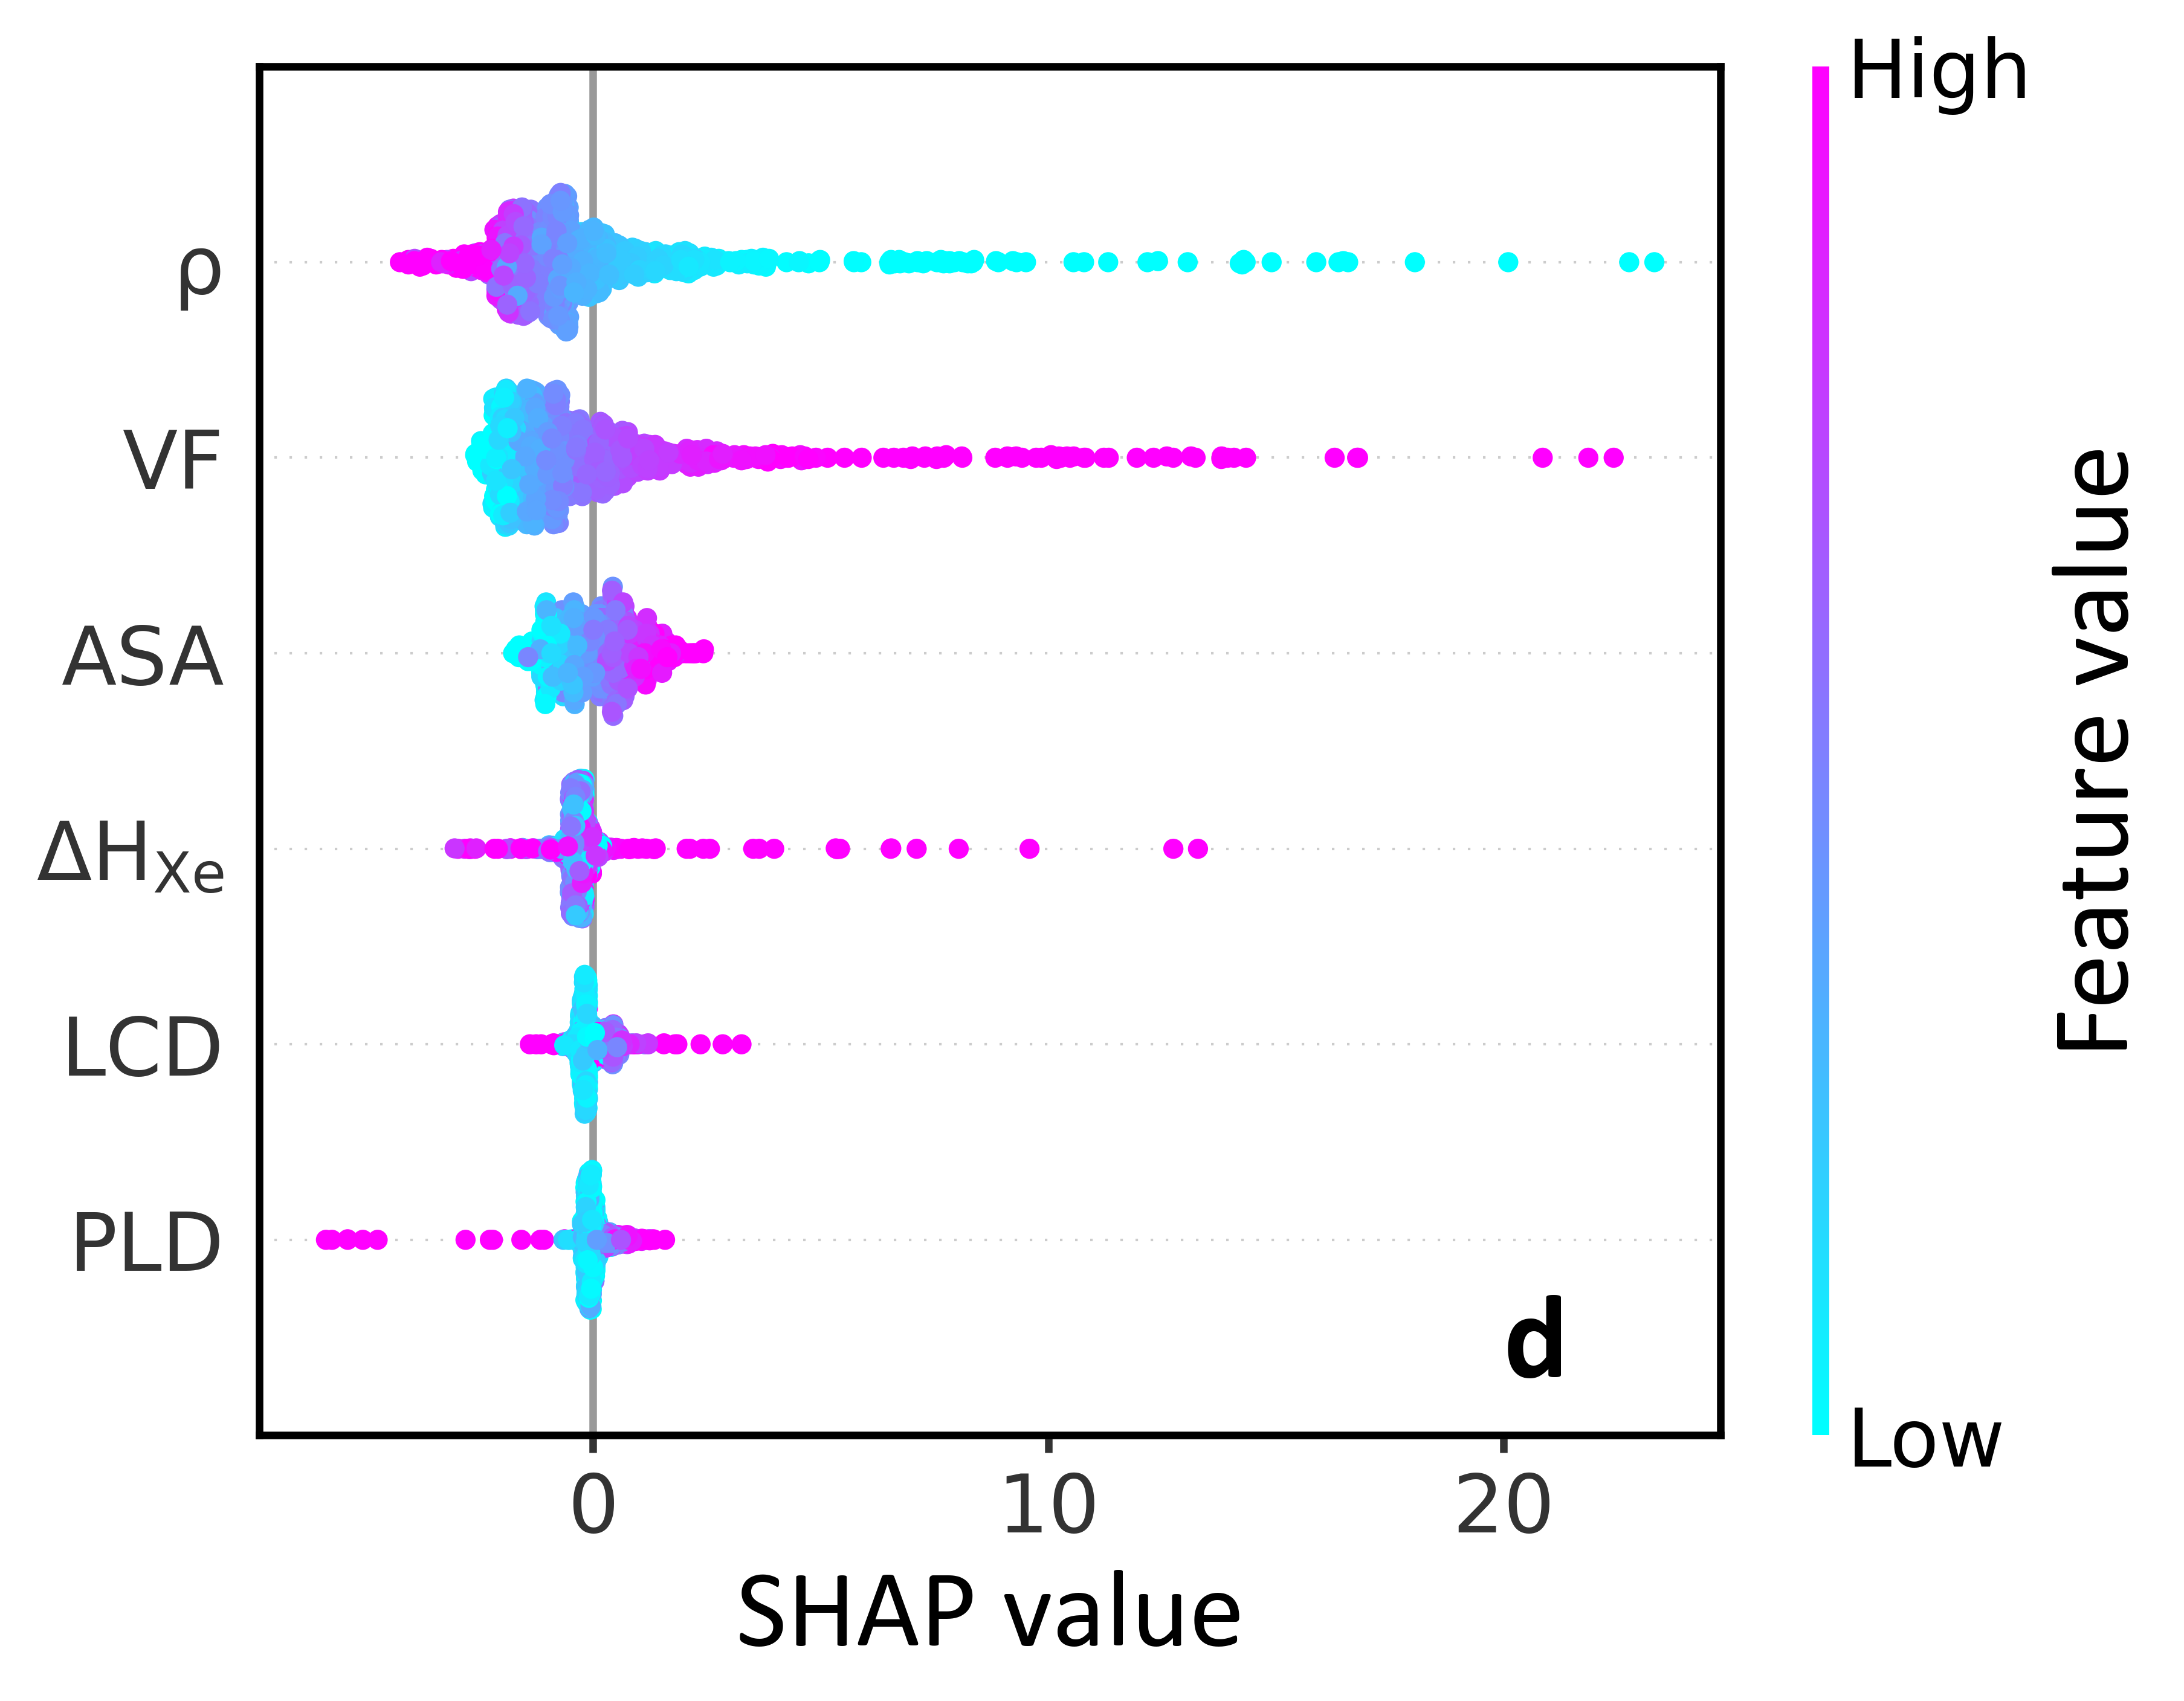

In [44]:
beeswarm(shap_values_Kr,color=pl.get_cmap("cool"))